In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from pandas.errors import ParserWarning

warnings.simplefilter(action='ignore', category=ParserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import utils.data as datutils

In [2]:
mah_df_dict = {}
dir = 'data/gadgetx3k_20/AHFHaloHistory/'
for f in sorted(os.listdir(dir)):
    file = dir + f
    mm0 = datutils.get_mah(file)
    id = datutils.find_id(file)
    mah_df_dict[id] = mm0

In [3]:
dsdf = pd.read_csv(
    'data/gadgetx3k_20/G3X_progenitors/DS_G3X_snap_128_center-cluster_progenitors.txt',
    sep=r'\s+', header=0)

int_columns = [0, 1, 2, 7]
column_names = dsdf.columns

for idx in range(len(column_names)):
    col_name = column_names[idx]
    if idx in int_columns:
        dsdf[col_name] = dsdf[col_name].astype(int)
    else:
        dsdf[col_name] = dsdf[col_name].astype(float)
dsdf.drop(columns=['Hid[1]', 'DS_200[2]', 'DS_500[7]'], inplace=True)
dsdf.set_index('rID[0]', inplace=True)

In [4]:
zs = [x['Redshift'].to_list() for x in mah_df_dict.values()]
redshifts = []
for z in zs:
    redshifts.extend(z)

redshifts = sorted(list(set(redshifts)))

In [5]:
corrs_list = []
filtered_z = []
mah_ds_dict = {}

for z in redshifts:
    mah_df = pd.DataFrame(columns=['ID', 'M/M0'])
    
    for region in mah_df_dict.keys():
        row = mah_df_dict[region].loc[mah_df_dict[region]
                                      ['Redshift'] == z, ['M/M0']]
        row['ID'] = region
        if not row.empty:
            mah_df = pd.concat([mah_df, row], ignore_index=True)
        
    if len(mah_df) < 200:
        continue
          
    filtered_z.append(z)

    df = mah_df.reset_index().merge(
        dsdf.reset_index(),
        left_on='ID',
        right_on='rID[0]',
        how='inner'
    )

    df.set_index('ID', inplace=True)
    df.drop('rID[0]', axis=1, inplace=True)
    mah_ds_dict[z] = df
    corrs = df.corr(method='spearman')
    corrs_list.append(corrs)


z_array = np.array(filtered_z)
aexp = 1/(1+z_array)

In [6]:
eta_200 = [df.loc['eta_200[3]', 'M/M0'] for df in corrs_list]
delta_200 = [df.loc['delta_200[4]', 'M/M0'] for df in corrs_list]
fm_200 = [df.loc['fm_200[5]', 'M/M0'] for df in corrs_list]
fm2_200 = [df.loc['fm2_200[6]', 'M/M0'] for df in corrs_list]
eta_500 = [df.loc['eta_500[8]', 'M/M0'] for df in corrs_list]
delta_500 = [df.loc['delta_500[9]', 'M/M0'] for df in corrs_list]
fm_500 = [df.loc['fm_500[10]', 'M/M0'] for df in corrs_list]
fm2_500 = [df.loc['fm2_500[11]', 'M/M0'] for df in corrs_list]

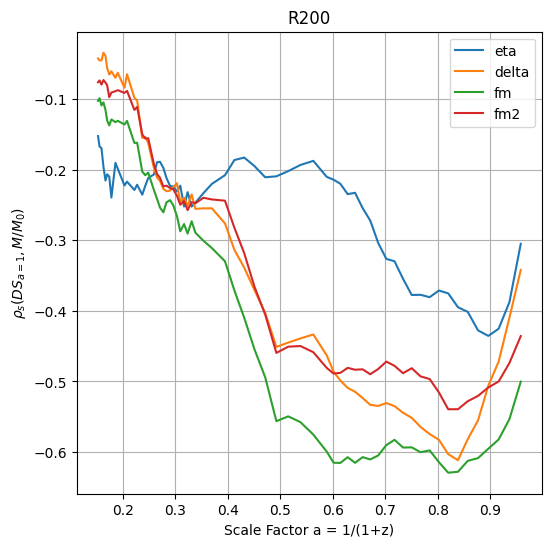

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axs.set_title('R200')
axs.plot(aexp, eta_200, label='eta')
axs.plot(aexp, delta_200, label='delta')
axs.plot(aexp, fm_200, label='fm')
axs.plot(aexp, fm2_200, label='fm2')
axs.set_xlabel('Scale Factor a = 1/(1+z)')
axs.set_ylabel(r'$\rho_s (DS_{a=1}, M/M_0)$')
axs.grid()
# plt.gca().invert_xaxis()
plt.legend()
plt.show()

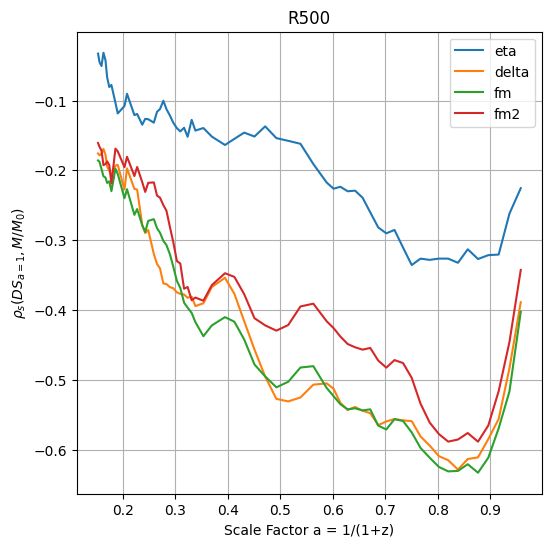

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axs.set_title('R500')
axs.plot(aexp, eta_500, label='eta')
axs.plot(aexp, delta_500, label='delta')
axs.plot(aexp, fm_500, label='fm')
axs.plot(aexp, fm2_500, label='fm2')
axs.set_xlabel('Scale Factor a = 1/(1+z)')
axs.set_ylabel(r'$\rho_s (DS_{a=1}, M/M_0)$')
axs.grid()
# plt.gca().invert_xaxis()
plt.legend()
plt.show()

In [9]:
fm2_200_p10 = datutils.get_perc(mah_ds_dict, param='fm2_200[6]', q=10)
fm2_200_p25 = datutils.get_perc(mah_ds_dict, param='fm2_200[6]', q=25)
fm2_200_p50 = datutils.get_perc(mah_ds_dict, param='fm2_200[6]', q=50)
fm2_200_p75 = datutils.get_perc(mah_ds_dict, param='fm2_200[6]', q=75)
fm2_200_p90 = datutils.get_perc(mah_ds_dict, param='fm2_200[6]', q=90)

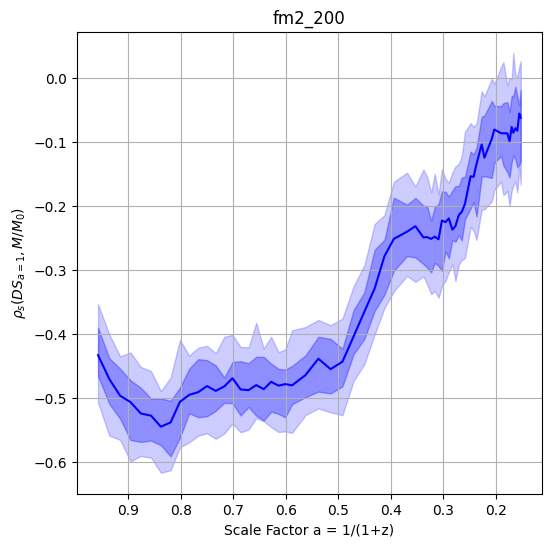

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axs.set_title('fm2_200')
axs.plot(aexp, fm2_200_p50, color='b')
axs.fill_between(aexp, fm2_200_p10, fm2_200_p90, color='b', alpha=0.2)
axs.fill_between(aexp, fm2_200_p25, fm2_200_p75, color='b', alpha=0.3)
axs.set_xlabel('Scale Factor a = 1/(1+z)')
axs.set_ylabel(r'$\rho_s (DS_{a=1}, M/M_0)$')
plt.gca().invert_xaxis()
axs.grid()
plt.show()

### Now for aexp(M/M0)...

In [5]:
size = 100  
mm0 = np.linspace(1e-5, 1, size)      # set up mah array
mm0_dict = {}
for m in mm0:
    # create dataframe for each mm0 value
    mm0_dict[m] = pd.DataFrame(columns=['aexp'])

In [6]:
tol = 1e-2
for mah in mah_df_list:
    # For each row in each mah snap, if it is close to an mm0 value then go to
    # dataframe at corresponding mm0_dict key and add the row(s) to that df.
    # In the end, for each mm0 value there is a df of aexp values.
    for m in mm0:
        err = np.abs((mah['M/M0'] - m))
        mask = err < tol
        mm0_dict[m] = pd.concat([mm0_dict[m], mah['aexp'][mask]])

In [7]:
# now we assemble the dictionary of ds+aexp params
# each key is an mm0 val, each val is the joint df
ds_aexp_dict = {}
for k, df in mm0_dict.items():
   if len(df) > len(dsdf):
      df1 = df.sample(len(dsdf))
      df2 = dsdf
   else:
      df1 = df
      df2 = dsdf.sample(len(dsdf))
   ds_aexp_dict[k] = pd.concat([df2.reset_index(drop=True),
                                df1.reset_index(drop=True)], axis=1)

In [ ]:
ds_aexp_corrs = {}
for k, v in ds_aexp_dict.items():
    ds_aexp_corrs[k] = v.corr(method='spearman')

In [ ]:
eta_200 = [df.loc['eta_200[3]', 'aexp'] for _, df in ds_aexp_corrs.items()]
delta_200 = [df.loc['delta_200[4]', 'aexp'] for _, df in ds_aexp_corrs.items()]
fm_200 = [df.loc['fm_200[5]', 'aexp'] for _, df in ds_aexp_corrs.items()]
fm2_200 = [df.loc['fm2_200[6]', 'aexp'] for _, df in ds_aexp_corrs.items()]
eta_500 = [df.loc['eta_500[8]', 'aexp'] for _, df in ds_aexp_corrs.items()]
delta_500 = [df.loc['delta_500[9]', 'aexp'] for _, df in ds_aexp_corrs.items()]
fm_500 = [df.loc['fm_500[10]', 'aexp'] for _, df in ds_aexp_corrs.items()]
fm2_500 = [df.loc['fm2_500[11]', 'aexp'] for _, df in ds_aexp_corrs.items()]

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
fig.suptitle('R200')

axs[0, 0].plot(mm0, eta_200, label='eta')
axs[0, 0].grid()
axs[0, 0].legend()

axs[0, 1].plot(mm0, delta_200, label='delta')
axs[0, 1].grid()
axs[0, 1].legend()

axs[1, 0].plot(mm0, fm_200, label='fm')
axs[1, 0].grid()
axs[1, 0].legend()

axs[1, 1].plot(mm0, fm2_200, label='fm2')
axs[1, 1].grid()
axs[1, 1].legend()

axs[1, 0].set_xlabel('M/M0')
axs[1, 1].set_xlabel('M/M0')
axs[0, 0].set_ylabel(r'$\rho_s (DS_{a=1},aexp)$')
axs[1, 0].set_ylabel(r'$\rho_s (DS_{a=1},aexp)$')

plt.tight_layout()
plt.legend()
plt.show()

### Gonna try this using Ismael's code

In [12]:
from multicam.mah import get_am
from scipy.interpolate import interp1d

In [14]:
# 1. Define common aexp grid (e.g. 100 steps from a=0.05 to a=1.0)
aexp = 1/(1+np.array(redshifts))
min_a = np.min(aexp)
max_a = np.max(aexp)
common_aexp = np.linspace(min_a+0.1, max_a-0.1, 80)

# 2. Build ma array (n_halos, n_timesteps)
mah = np.full((len(mah_df_dict), len(common_aexp)),
             np.nan)  # fill with NaN for safety

for i, df in enumerate(mah_df_dict.values()):
    a = df['aexp'].values
    m = df['M/M0'].values

    # Make sure a and m are sorted by a
    sort_idx = np.argsort(a)
    a_sorted = a[sort_idx]
    m_sorted = m[sort_idx]

    # Only interpolate over increasing a
    interp_func = interp1d(
        a_sorted, m_sorted,
        bounds_error=False,
        fill_value=np.nan  # leave outside values as nan
    )

    mah[i] = interp_func(common_aexp)

# Now call get_am
am, mbins = get_am(ma=mah, scales=common_aexp, min_mass_bin=1e-5)

In [15]:
mah_files = sorted(os.listdir('data/gadgetx3k_20/AHFHaloHistory'))
ids = [datutils.find_id(f) for f in mah_files]

In [16]:
am_df = pd.DataFrame(am)
ind_cols = am_df.columns
am_df['ID'] = ids
am_df.set_index('ID', inplace=True)

In [17]:
filtered_mbins = []
corrs_list = []
size = len(am_df)
for col in ind_cols:
    mah_df = am_df[col].dropna()
    if len(mah_df) < 20: continue

    filtered_mbins.append(mbins[col])

    df = mah_df.reset_index().merge(
        dsdf.reset_index(),
        left_on='ID',
        right_on='rID[0]',
        how='inner'
    )

    df.set_index('ID', inplace=True)
    df.drop('rID[0]', axis=1, inplace=True)
    corrs = df.corr(method='spearman')
    corrs_list.append(corrs)

In [18]:
eta_200 = [df.loc['eta_200[3]', df.columns[0]] for df in corrs_list]
delta_200 = [df.loc['delta_200[4]', df.columns[0]] for df in corrs_list]
fm_200 = [df.loc['fm_200[5]', df.columns[0]] for df in corrs_list]
fm2_200 = [df.loc['fm2_200[6]', df.columns[0]] for df in corrs_list]
eta_500 = [df.loc['eta_500[8]', df.columns[0]] for df in corrs_list]
delta_500 = [df.loc['delta_500[9]', df.columns[0]] for df in corrs_list]
fm_500 = [df.loc['fm_500[10]', df.columns[0]] for df in corrs_list]
fm2_500 = [df.loc['fm2_500[11]', df.columns[0]] for df in corrs_list]

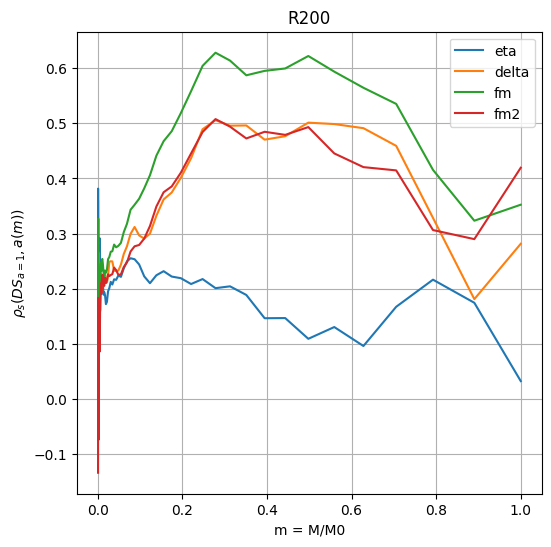

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axs.set_title('R200')
axs.plot(filtered_mbins, eta_200, label='eta')
axs.plot(filtered_mbins, delta_200, label='delta')
axs.plot(filtered_mbins, fm_200, label='fm')
axs.plot(filtered_mbins, fm2_200, label='fm2')
axs.set_xlabel('m = M/M0')
axs.set_ylabel(r'$\rho_s (DS_{a=1}, a(m))$')
axs.grid()
# plt.gca().invert_xaxis()
plt.legend()
plt.show()